# Adding expression data and visualizing a network                       

Applications that were used: Cytoscape (v.3.8.2) and Jupyter Notebooks (v.2.2.6) through the Anaconda navigator (v.1.10.0).

In Cytoscape, the following app was installed: FileTransfer (v.1.1) for communication to Jupyter notebooks. 
To install apps in Cytoscape go to Apps -> App Manager -> Search

For those new to working with Jupyter Notebooks, go to the [MarkDown Tutorial](https://www.markdowntutorial.com/lesson/1/) to learn how to comment your code properly. 

Now let's move on to the code. 

#### Here we will load a previously extended network and visualize expression and significance. 

## Step 1a: Importing required packages

In [2]:
import os
import sys
import requests
import pandas as pd
import py4cytoscape as p4c
from lxml import etree as ET

## Step 1b: Load code that prevents unwanted logging error

In [3]:
from logging import getLogger, INFO
from concurrent_log_handler import ConcurrentRotatingFileHandler

In [4]:
log = getLogger()
# Use an absolute path to prevent file rotation trouble.
logfile = os.path.abspath("py4cytoscape.log")
# Rotate log after reaching 512K, keep 5 old copies.
rotateHandler = ConcurrentRotatingFileHandler(logfile, "a", 512*1024, 5)
log.addHandler(rotateHandler)
log.setLevel(INFO)

log.info("Here is a very exciting log message, just for you")

Check py4cytoscape version.

In [5]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.8.2',
 'automationAPIVersion': '1.2.0',
 'py4cytoscapeVersion': '0.0.9'}

## Step 2: Loading an existing network

We are using a previously created network in .cys format. First we will define a new variable to the file path and then a new variable to the path+file name. You can also import files of different formats, such as the .sif format. Look into py4cytoscape documentation on how to import different file types. 

In [6]:
path = 'C:/Users/stefa/Documents/GitHub/2021-internship/Raats/'
file_name = path + 'networkExtended.cys'
file_name

'C:/Users/stefa/Documents/GitHub/2021-internship/Raats/networkExtended.cys'

Now let us  load this network in cytoscape.

In [7]:
abs_file_name = os.path.abspath(file_name)

In [8]:
session_cmd_list = ['session','open','file="',abs_file_name,'"']
session_cmd = " ".join(session_cmd_list)

In [9]:
p4c.commands.commands_run(session_cmd)

[]

## Step 3a: Loading Expression Data
Great! Our network is loaded. Now we will move on to loading the expression data.  
First we will define the path of our expression data file. Next, we will define a new dataframe with the information in our expression data file. To check whether it was loaded correctly, we view the first 5 rows using df.head()

In [10]:
expression_file = path + 'expDatafile.csv'
df=pd.read_csv(expression_file)
df.head()

,Unnamed: 0,logFC,logCPM,F,PValue,FDR
0,SAA2,2.414265,5.432500,512.091071,1.406545e-12,1.877738e-08
1,CCL20,3.133684,4.949061,447.918174,3.560546e-12,2.376665e-08
2,IL36G,2.722310,4.359048,340.454929,2.359692e-11,1.050063e-07
3,INHBA,1.810556,6.511435,272.793242,1.071872e-10,3.577374e-07
4,TNFAIP3,1.601914,7.418585,263.426641,1.358966e-10,3.628440e-07


In [10]:
len(df)

13350

### len() shows us that 13350 out of 21788 rows have been loaded. 0 counts have been filtered by processing

Now we define what column the data will be linked to. We want the row with gene A and the corresponding values to be added in the row of gene A in the pathway. In the dataset, the first column with gene names is called "Unnamed:0". Consequently, we select this column in the following code.     

Note this gives a SettingWithCopyWarning, this is okay. 

In [11]:
p4c.load_table_data(df, data_key_column="Unnamed: 0")

C:\Users\stefa\anaconda3\lib\site-packages\py4cytoscape\tables.py:474: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


'Success: Data loaded in defaultnode table'

## Step 3b: Visualizing the network  
Now we will start visualizing the network. First, I wish to know my column names so I do not make any mistakes further in the code. 

In [12]:
p4c.tables.get_table_column_names('node')

['SUID',
 'shared name',
 'name',
 'selected',
 'GraphID',
 'Type',
 'XrefId',
 'XrefDatasource',
 'Color',
 'Border Width',
 'Node Size',
 'Label Font Size',
 'Ensembl',
 'CTL.Ext',
 'CTL.Type',
 'CTL.PathwayName',
 'CTL.label',
 'CTL.PathwayID',
 'CTL.GeneName',
 'CTL.GeneID',
 'Unnamed: 0',
 'logFC',
 'logCPM',
 'F',
 'PValue',
 'FDR']

## Step 4a: Adding expression visualizations

Expression data is under the column "logFC" in our dataset. We assign a white colour to values close to 0, a blue colour to values of -1 or less, and a red colour to values of 1 or greater. We apply this mapping to the style 'WikiPathways'. Leave this blank to update the default style. 

In [13]:
p4c.set_node_color_mapping('logFC', table_column_values=[-1, 0,  1], colors=['#0000FF', '#FFFFFF', '#FF0000'], style_name='CyTargetLinker_0')

''

## Step 4b: Viewing our Expression output

This file already exists. A Cytoscape popup will be generated to confirm overwrite.


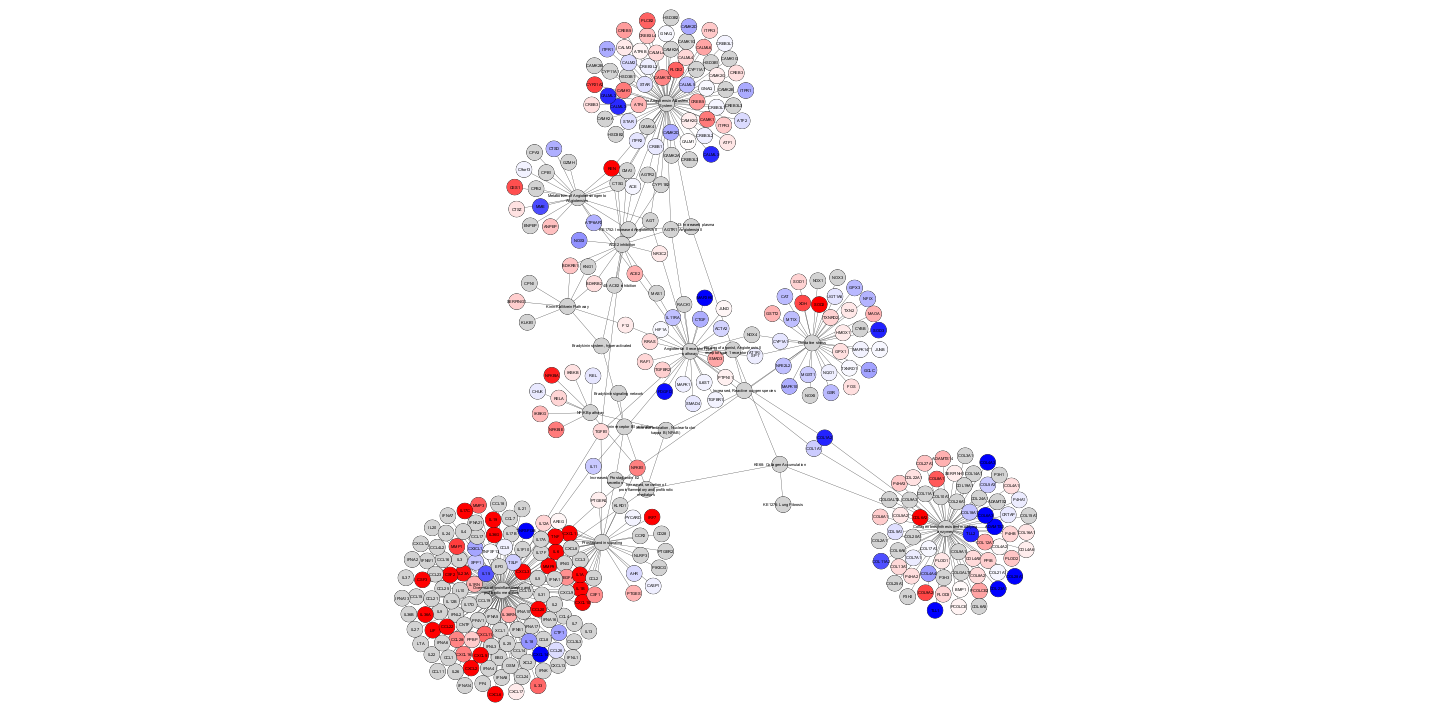

In [15]:
p4c.export_image(filename='expNetwork.png', resolution=600)
p4c.sandbox_get_from('expNetwork.png')
from IPython.display import Image
Image('expNetwork.png')

## Step 4c: Significance visualizations

Now we will assign a light green border colour to all genes that are significantly upregulated or downregulated. To do this, we make a list of the genes, which we pass to the color bypass code. The column 'PValue' is the column in our dataset where significance is annotated.   

Finally, to make it easier to view, we increase the border width size.   

Note that it is not necessary to include the style name when using the bypass option.     

Also note there is a Cytoscape warning, that is okay. 

In [16]:
sig_gene_list = p4c.create_column_filter('sig_gene_list','PValue', 0.05, "LESS_THAN")

Warning -- Cytoscape version pre-3.9 in use ... settling delay inserted after filter execution


No edges selected.


In [ ]:
sig_gene_list

In [17]:
dfSigGene = pd.DataFrame(sig_gene_list)
dfSigGene.head()

,nodes,edges
0,ATF4,None
1,ITPR3,None
2,ITPR1,None
3,ITPR1,None
4,ITPR3,None


In [18]:
col_one_list = dfSigGene['nodes'].tolist()
print(f"\ncol_one_list:\n{col_one_list}\ntype:{type(col_one_list)}")


col_one_list:
['ATF4', 'ITPR3', 'ITPR1', 'ITPR1', 'ITPR3', 'CAMK2D', 'CAMK2D', 'CALML3', 'CALML3', 'CALML3', 'IL1RN', 'IL36A', 'TNF', 'CXCL10', 'MMP9', 'IL23A', 'CXCL1', 'CCL28', 'CCL20', 'MMP1', 'CSF2', 'CXCL3', 'CXCL6', 'CSF1', 'CSF3', 'IL15', 'LIF', 'VEGFA', 'IL33', 'CXCL14', 'CXCL2', 'CTGF', 'CXCL5', 'NFKB1', 'MAP2K6', 'IL36G', 'IL6', 'SMAD3', 'IL1B', 'IL1A', 'TGFBR2', 'IL17C', 'CXCL16', 'PTGES', 'IRF7', 'TLL2', 'COL8A1', 'TLL1', 'ATP6AP2', 'MME', 'CES1', 'COL12A1', 'PPIB', 'NFIX', 'GSR', 'MT1X', 'XDH', 'GPX3', 'MAOA', 'CAT', 'GCLC', 'SOD2', 'MAPK10', 'NFE2L2', 'NFKBIE', 'NFKBIA']
type:<class 'list'>


In [19]:
p4c.set_node_border_color_bypass(col_one_list,'#90ee90')

''

In [20]:
p4c.set_node_border_width_default(10, style_name='CyTargetLinker_0')

''

## Step 4d: Viewing our output in Jupyter

This file already exists. A Cytoscape popup will be generated to confirm overwrite.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


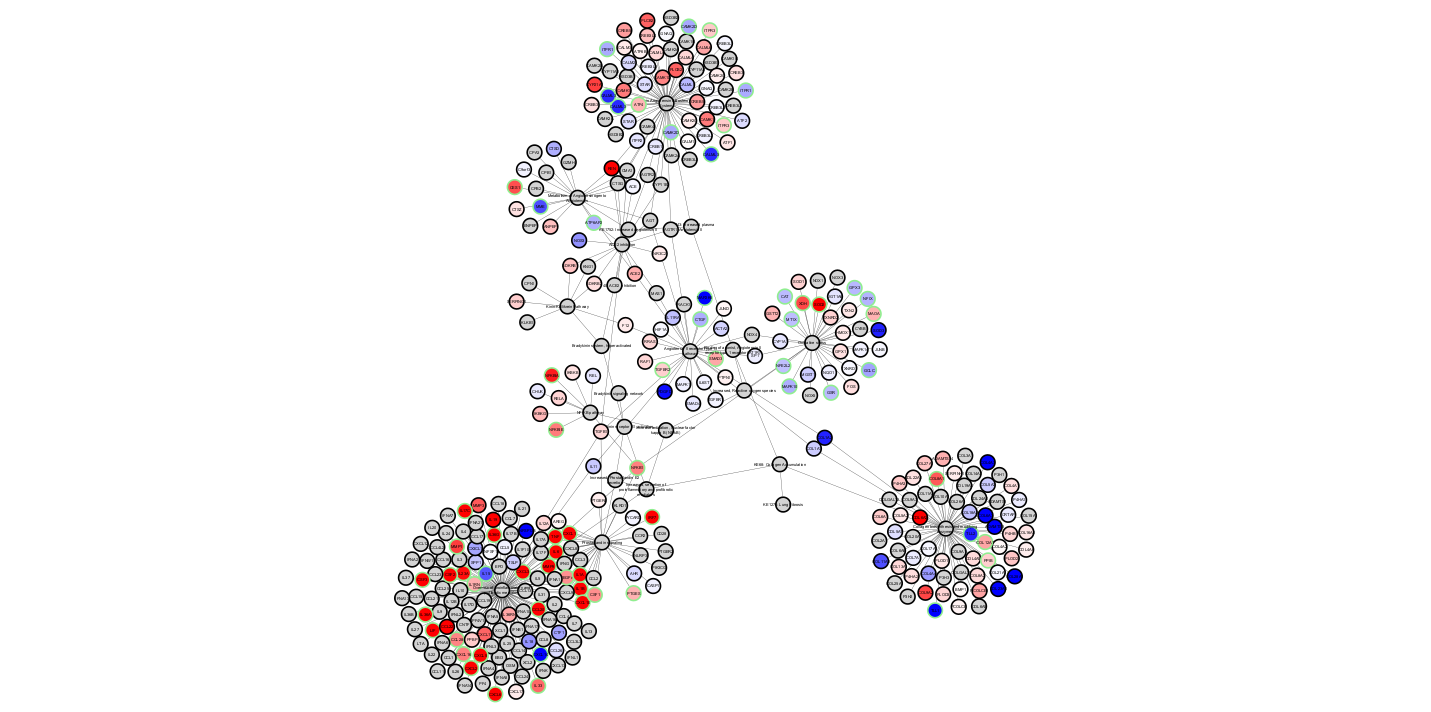

In [22]:
p4c.export_image(filename='sigGreen.png')
p4c.sandbox_get_from('sigGreen.png')
from IPython.display import Image

p4c.export_image(filename='sigGreen.svg', type='SVG')
p4c.sandbox_get_from('sigGreen.svg')

Image('sigGreen.png')